In [ ]:
"""
**************************************
*  @Author  ：   mag1cfox
*  @Time    ：   2025/3/20 10:30
*  @Project :   pj_gptp_simulation
*  @Description :   Description
*  @FileName:   main20250320.py
**************************************
"""
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


class TimeAwareSystem:
    def __init__(self, id, initial_drift_rate=None):
        self.id = id
        # 随机初始化时钟漂移率 [-10, 10] ppm
        if initial_drift_rate is None:
            self.initial_drift_rate = np.random.uniform(-10e-6, 10e-6)
        else:
            self.initial_drift_rate = initial_drift_rate

        self.drift_rate = self.initial_drift_rate
        self.drift_rate_change = 0
        self.clock_time = 0
        self.last_sync_time = 0
        self.neighbor_rate_ratio = 1.0

        # 传播延迟测量结果
        self.propagation_delay = 0
        self.propagation_delay_history = []

        # 同步记录
        self.time_errors = []

    def update_clock(self, time_step):
        # 更新时钟漂移率变化 (最大1ppm/s)
        self.drift_rate_change += np.random.uniform(0, 1e-6 * time_step)
        self.drift_rate = self.initial_drift_rate + self.drift_rate_change

        # 更新时钟时间
        self.clock_time += time_step * (1 + self.drift_rate)

    def calculate_neighbor_rate_ratio(self, previous_tas):
        # 计算邻居速率比
        exact_ratio = (1 + previous_tas.drift_rate) / (1 + self.drift_rate)
        # 添加最大0.1ppm的误差
        error = np.random.uniform(-0.1e-6, 0.1e-6)
        self.neighbor_rate_ratio = exact_ratio + error
        return self.neighbor_rate_ratio

    def measure_propagation_delay(self, previous_tas, real_delay=50e-9):
        # PHY抖动 [0, 8] ns
        jitter1 = np.random.uniform(0, 8e-9)
        jitter2 = np.random.uniform(0, 8e-9)
        jitter3 = np.random.uniform(0, 8e-9)
        jitter4 = np.random.uniform(0, 8e-9)

        # 时钟粒度 8ns
        granularity = 8e-9

        # t1: 发送Pdelay_Req的时间
        t1 = self.clock_time + np.random.uniform(0, granularity)

        # t2: 接收Pdelay_Req的时间
        t2_perfect = t1 * (1 + self.drift_rate) / (1 + previous_tas.drift_rate) + real_delay + jitter1
        t2 = t2_perfect - (t2_perfect % granularity) + np.random.uniform(0, granularity)

        # t3: 发送Pdelay_Resp的时间
        t3 = t2 + 1e-3  # 1ms的驻留时间

        # t4: 接收Pdelay_Resp的时间
        t4_perfect = t3 * (1 + previous_tas.drift_rate) / (1 + self.drift_rate) + real_delay + jitter2
        t4 = t4_perfect - (t4_perfect % granularity) + np.random.uniform(0, granularity)

        # 根据公式(4)计算传播延迟
        measured_delay = 0.5 * ((t4 - t1) - self.neighbor_rate_ratio * (t3 - t2))
        self.propagation_delay = measured_delay
        self.propagation_delay_history.append(measured_delay)

        # 使用累积平均值
        if len(self.propagation_delay_history) > 1:
            self.propagation_delay = np.mean(self.propagation_delay_history)

        return self.propagation_delay

    def receive_sync(self, previous_tas, gm_time, sync_info):
        # 记录接收时间
        receive_time = self.clock_time

        # PHY抖动
        jitter = np.random.uniform(0, 8e-9)

        # 时钟粒度
        granularity = 8e-9
        receive_time_with_error = receive_time + jitter
        receive_time_with_error = receive_time_with_error - (receive_time_with_error % granularity) + np.random.uniform(
            0, granularity)

        # 提取同步信息
        origin_timestamp, correction_field, rate_ratio = sync_info

        # 更新速率比 - 公式(1)
        updated_rate_ratio = rate_ratio * self.neighbor_rate_ratio

        # 计算从接收到发送的驻留时间
        residence_time = np.random.uniform(0, 1e-3)  # 最大1ms

        # 更新修正字段 - 公式(2)
        updated_correction_field = correction_field + self.propagation_delay + (residence_time * updated_rate_ratio)

        # 计算主时钟时间 - 公式(3)
        estimated_gm_time = origin_timestamp + updated_correction_field

        # 计算并记录时间误差
        time_error = receive_time - estimated_gm_time
        self.time_errors.append((gm_time, time_error))

        # 更新本地时钟
        self.clock_time = estimated_gm_time
        self.last_sync_time = receive_time

        # 返回更新后的同步信息
        send_time = self.clock_time + residence_time
        return send_time, (origin_timestamp, updated_correction_field, updated_rate_ratio)


def run_simulation(num_tas=100, duration=100, sync_interval=31.25e-3, pdelay_interval=1.0):
    # 创建时间感知系统
    tas_list = [TimeAwareSystem(i) for i in range(num_tas + 1)]  # +1 for grandmaster

    # 主时钟
    grandmaster = tas_list[0]

    # 仿真时间
    current_time = 0
    next_sync_time = 0
    next_pdelay_time = 0

    # 用于存储结果的数据结构
    sync_precision_data = {i: [] for i in range(1, num_tas + 1)}

    # 主循环
    with tqdm(total=int(duration / sync_interval)) as pbar:
        while current_time < duration:
            # 更新所有时钟
            time_step = min(sync_interval / 10,
                            next_sync_time - current_time if next_sync_time > current_time else sync_interval / 10)
            for tas in tas_list:
                tas.update_clock(time_step)

            current_time += time_step

            # 执行同步
            if current_time >= next_sync_time:
                # 主时钟发送同步信息
                sync_time = grandmaster.clock_time
                sync_info = (sync_time, 0, 1.0)  # (origin_timestamp, correction_field, rate_ratio)

                # 沿链路传递同步信息
                for i in range(1, num_tas + 1):
                    prev_tas = tas_list[i - 1]
                    current_tas = tas_list[i]

                    # 如果这是第一次同步，先测量传播延迟
                    if not current_tas.propagation_delay_history:
                        current_tas.calculate_neighbor_rate_ratio(prev_tas)
                        current_tas.measure_propagation_delay(prev_tas)

                    # 接收同步信息并更新
                    _, sync_info = current_tas.receive_sync(prev_tas, grandmaster.clock_time, sync_info)

                    # 记录同步精度
                    time_error = abs(current_tas.clock_time - grandmaster.clock_time)
                    sync_precision_data[i].append((current_time, time_error))

                next_sync_time = current_time + sync_interval
                pbar.update(1)

            # 执行传播延迟测量
            if current_time >= next_pdelay_time:
                for i in range(1, num_tas + 1):
                    prev_tas = tas_list[i - 1]
                    current_tas = tas_list[i]
                    current_tas.calculate_neighbor_rate_ratio(prev_tas)
                    current_tas.measure_propagation_delay(prev_tas)

                next_pdelay_time = current_time + pdelay_interval

    return tas_list, sync_precision_data


def analyze_results(tas_list, sync_precision_data, precision_thresholds=[0.5e-6, 1e-6, 1.5e-6, 2e-6]):
    # 同步精度概率分析
    precision_probabilities = {threshold: {} for threshold in precision_thresholds}

    for threshold in precision_thresholds:
        for tas_id in sync_precision_data:
            in_sync_count = sum(1 for _, error in sync_precision_data[tas_id] if error < threshold)
            total_count = len(sync_precision_data[tas_id])
            probability = in_sync_count / total_count if total_count > 0 else 0
            precision_probabilities[threshold][tas_id] = probability

    # 绘制同步精度概率图
    plt.figure(figsize=(10, 6))
    for threshold in precision_thresholds:
        tas_ids = list(precision_probabilities[threshold].keys())
        probabilities = list(precision_probabilities[threshold].values())
        plt.plot(tas_ids, probabilities, label=f'< {threshold * 1e6:.1f} μs')

    plt.xlabel('Time-Aware System ID')
    plt.ylabel('Probability of Synchronization')
    plt.title('Probability of Synchronization within Different Precision Thresholds')
    plt.legend()
    plt.grid(True)
    plt.savefig('output_image/sync_probability.png')
    plt.close()

    # 绘制时间误差分布图（最后一个设备）
    last_tas_id = max(sync_precision_data.keys())
    errors = [error for _, error in sync_precision_data[last_tas_id]]

    plt.figure(figsize=(10, 6))
    plt.hist(np.array(errors) * 1e6, bins=50, alpha=0.7)
    plt.xlabel('Time Deviation (μs)')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Time Deviation for TAS {last_tas_id}')
    plt.grid(True)
    plt.savefig('output_image/time_deviation_distribution.png')
    plt.close()

    # 绘制1μs同步概率曲线
    tas_ids = list(precision_probabilities[1e-6].keys())
    probabilities = list(precision_probabilities[1e-6].values())

    plt.figure(figsize=(10, 6))
    plt.plot(tas_ids, probabilities)
    plt.xlabel('Time-Aware System ID')
    plt.ylabel('Probability of Synchronization')
    plt.title('Probability of Synchronization within 1 μs')
    plt.grid(True)
    # plt.ylim(0, 1.05)
    plt.savefig('output_image/sync_probability_1us.png')
    plt.close()

    # 返回结果
    return precision_probabilities


def propagation_delay_simulation():
    # 模拟传播延迟测量
    tas1 = TimeAwareSystem(1, initial_drift_rate=5e-6)  # 5ppm
    tas2 = TimeAwareSystem(2, initial_drift_rate=-3e-6)  # -3ppm

    delays = []
    avg_delays = []
    cumulative_avg = 0

    for i in range(1000):
        tas1.update_clock(1.0)  # 更新1秒
        tas2.update_clock(1.0)

        tas2.calculate_neighbor_rate_ratio(tas1)
        delay = tas2.measure_propagation_delay(tas1)
        delays.append(delay)

        cumulative_avg = (cumulative_avg * i + delay) / (i + 1) if i > 0 else delay
        avg_delays.append(cumulative_avg)

    # 绘制传播延迟图
    plt.figure(figsize=(10, 6))
    plt.plot(delays, 'k-', label='Measured Delay')
    plt.plot(avg_delays, 'r-', label='Cumulative Average')
    plt.axhline(y=50e-9, color='b', linestyle='--', label='Real Delay (50 ns)')
    plt.xlabel('Measurement Number')
    plt.ylabel('Propagation Delay (s)')
    plt.title('Propagation Delay Measurements')
    plt.legend()
    plt.grid(True)
    # plt.ylim(0, 100e-9)
    plt.savefig('output_image/propagation_delay.png')
    plt.close()

    # 打印结果
    print(f"Average measured delay: {np.mean(delays) * 1e9:.2f} ns")
    print(f"Final cumulative average: {cumulative_avg * 1e9:.2f} ns")
    print(f"Min delay: {min(delays) * 1e9:.2f} ns")
    print(f"Max delay: {max(delays) * 1e9:.2f} ns")


if __name__ == "__main__":
    # 运行传播延迟仿真
    print("Running propagation delay simulation...")
    propagation_delay_simulation()

    # 运行主仿真
    print("\nRunning main simulation...")
    tas_list, sync_precision_data = run_simulation(num_tas=100, duration=100, sync_interval=31.25e-3)

    # 分析结果
    print("\nAnalyzing results...")
    precision_probabilities = analyze_results(tas_list, sync_precision_data)

    # 打印结果摘要
    print("\nSimulation completed!")
    print(f"Number of time-aware systems: {len(tas_list) - 1}")
    print(f"Synchronization interval: 31.25 ms")

    # 打印不同跳数设备的同步精度概率
    for hop in [10, 30, 50, 100]:
        if hop in precision_probabilities[1e-6]:
            print(f"Probability of synchronization within 1 μs for TAS {hop}: {precision_probabilities[1e-6][hop]:.4f}")

    print("\nResults saved as images:")
    print("- sync_probability.png")
    print("- time_deviation_distribution.png")
    print("- sync_probability_1us.png")
    print("- propagation_delay.png")


## 将代码拆成两部分，一部分是输出csv，一部分是画图。
### 1. 输出csv

In [1]:
"""
**************************************
*  @Author  ：   mag1cfox
*  @Time    ：   2025/3/20 10:30
*  @Project :   pj_gptp_simulation
*  @Description :   Run simulation and save results to CSV
*  @FileName:   simulation_runner.py
**************************************
"""
import numpy as np
from tqdm import tqdm
import csv
import os

class TimeAwareSystem:
    def __init__(self, id, initial_drift_rate=None):
        self.id = id
        # 随机初始化时钟漂移率 [-10, 10] ppm
        if initial_drift_rate is None:
            self.initial_drift_rate = np.random.uniform(-10e-6, 10e-6)
        else:
            self.initial_drift_rate = initial_drift_rate

        self.drift_rate = self.initial_drift_rate
        self.drift_rate_change = 0
        self.clock_time = 0
        self.last_sync_time = 0
        self.neighbor_rate_ratio = 1.0

        # 传播延迟测量结果
        self.propagation_delay = 0
        self.propagation_delay_history = []

        # 同步记录
        self.time_errors = []

    def update_clock(self, time_step):
        # 更新时钟漂移率变化 (最大1ppm/s)
        self.drift_rate_change += np.random.uniform(0, 1e-6 * time_step)
        self.drift_rate = self.initial_drift_rate + self.drift_rate_change

        # 更新时钟时间
        self.clock_time += time_step * (1 + self.drift_rate)

    def calculate_neighbor_rate_ratio(self, previous_tas):
        # 计算邻居速率比
        exact_ratio = (1 + previous_tas.drift_rate) / (1 + self.drift_rate)
        # 添加最大0.1ppm的误差
        error = np.random.uniform(-0.1e-6, 0.1e-6)
        self.neighbor_rate_ratio = exact_ratio + error
        return self.neighbor_rate_ratio

    def measure_propagation_delay(self, previous_tas, real_delay=50e-9):
        # PHY抖动 [0, 8] ns
        jitter1 = np.random.uniform(0, 8e-9)
        jitter2 = np.random.uniform(0, 8e-9)
        jitter3 = np.random.uniform(0, 8e-9)
        jitter4 = np.random.uniform(0, 8e-9)

        # 时钟粒度 8ns
        granularity = 8e-9

        # t1: 发送Pdelay_Req的时间
        t1 = self.clock_time + np.random.uniform(0, granularity)

        # t2: 接收Pdelay_Req的时间
        t2_perfect = t1 * (1 + self.drift_rate) / (1 + previous_tas.drift_rate) + real_delay + jitter1
        t2 = t2_perfect - (t2_perfect % granularity) + np.random.uniform(0, granularity)

        # t3: 发送Pdelay_Resp的时间
        t3 = t2 + 1e-3  # 1ms的驻留时间

        # t4: 接收Pdelay_Resp的时间
        t4_perfect = t3 * (1 + previous_tas.drift_rate) / (1 + self.drift_rate) + real_delay + jitter2
        t4 = t4_perfect - (t4_perfect % granularity) + np.random.uniform(0, granularity)

        # 根据公式(4)计算传播延迟
        measured_delay = 0.5 * ((t4 - t1) - self.neighbor_rate_ratio * (t3 - t2))
        self.propagation_delay = measured_delay
        self.propagation_delay_history.append(measured_delay)

        # 使用累积平均值
        if len(self.propagation_delay_history) > 1:
            self.propagation_delay = np.mean(self.propagation_delay_history)

        return self.propagation_delay

    def receive_sync(self, previous_tas, gm_time, sync_info):
        # 记录接收时间
        receive_time = self.clock_time

        # PHY抖动
        jitter = np.random.uniform(0, 8e-9)

        # 时钟粒度
        granularity = 8e-9
        receive_time_with_error = receive_time + jitter
        receive_time_with_error = receive_time_with_error - (receive_time_with_error % granularity) + np.random.uniform(
            0, granularity)

        # 提取同步信息
        origin_timestamp, correction_field, rate_ratio = sync_info

        # 更新速率比 - 公式(1)
        updated_rate_ratio = rate_ratio * self.neighbor_rate_ratio

        # 计算从接收到发送的驻留时间
        residence_time = np.random.uniform(0, 1e-3)  # 最大1ms

        # 更新修正字段 - 公式(2)
        updated_correction_field = correction_field + self.propagation_delay + (residence_time * updated_rate_ratio)

        # 计算主时钟时间 - 公式(3)
        estimated_gm_time = origin_timestamp + updated_correction_field

        # 计算并记录时间误差
        time_error = receive_time - estimated_gm_time
        self.time_errors.append((gm_time, time_error))

        # 更新本地时钟
        self.clock_time = estimated_gm_time
        self.last_sync_time = receive_time

        # 返回更新后的同步信息
        send_time = self.clock_time + residence_time
        return send_time, (origin_timestamp, updated_correction_field, updated_rate_ratio)


def run_simulation(num_tas=100, duration=100, sync_interval=31.25e-3, pdelay_interval=1.0):
    # 创建时间感知系统
    tas_list = [TimeAwareSystem(i) for i in range(num_tas + 1)]  # +1 for grandmaster

    # 主时钟
    grandmaster = tas_list[0]

    # 仿真时间
    current_time = 0
    next_sync_time = 0
    next_pdelay_time = 0

    # 用于存储结果的数据结构
    sync_precision_data = {i: [] for i in range(1, num_tas + 1)}

    # 主循环
    with tqdm(total=int(duration / sync_interval)) as pbar:
        while current_time < duration:
            # 更新所有时钟
            time_step = min(sync_interval / 10,
                            next_sync_time - current_time if next_sync_time > current_time else sync_interval / 10)
            for tas in tas_list:
                tas.update_clock(time_step)

            current_time += time_step

            # 执行同步
            if current_time >= next_sync_time:
                # 主时钟发送同步信息
                sync_time = grandmaster.clock_time
                sync_info = (sync_time, 0, 1.0)  # (origin_timestamp, correction_field, rate_ratio)

                # 沿链路传递同步信息
                for i in range(1, num_tas + 1):
                    prev_tas = tas_list[i - 1]
                    current_tas = tas_list[i]

                    # 如果这是第一次同步，先测量传播延迟
                    if not current_tas.propagation_delay_history:
                        current_tas.calculate_neighbor_rate_ratio(prev_tas)
                        current_tas.measure_propagation_delay(prev_tas)

                    # 接收同步信息并更新
                    _, sync_info = current_tas.receive_sync(prev_tas, grandmaster.clock_time, sync_info)

                    # 记录同步精度
                    time_error = abs(current_tas.clock_time - grandmaster.clock_time)
                    sync_precision_data[i].append((current_time, time_error))

                next_sync_time = current_time + sync_interval
                pbar.update(1)

            # 执行传播延迟测量
            if current_time >= next_pdelay_time:
                for i in range(1, num_tas + 1):
                    prev_tas = tas_list[i - 1]
                    current_tas = tas_list[i]
                    current_tas.calculate_neighbor_rate_ratio(prev_tas)
                    current_tas.measure_propagation_delay(prev_tas)

                next_pdelay_time = current_time + pdelay_interval

    return tas_list, sync_precision_data


def save_results_to_csv(sync_precision_data, filename="simulation_results.csv"):
    # 确保输出目录存在
    os.makedirs("output_data", exist_ok=True)
    
    with open(f"output_data/{filename}", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        # 写入表头
        writer.writerow(["TAS_ID", "Time", "Time_Error"])
        
        # 写入数据
        for tas_id in sync_precision_data:
            for time, error in sync_precision_data[tas_id]:
                writer.writerow([tas_id, time, error])


def propagation_delay_simulation():
    # 模拟传播延迟测量
    tas1 = TimeAwareSystem(1, initial_drift_rate=5e-6)  # 5ppm
    tas2 = TimeAwareSystem(2, initial_drift_rate=-3e-6)  # -3ppm

    delays = []
    avg_delays = []
    cumulative_avg = 0

    for i in range(1000):
        tas1.update_clock(1.0)  # 更新1秒
        tas2.update_clock(1.0)

        tas2.calculate_neighbor_rate_ratio(tas1)
        delay = tas2.measure_propagation_delay(tas1)
        delays.append(delay)

        cumulative_avg = (cumulative_avg * i + delay) / (i + 1) if i > 0 else delay
        avg_delays.append(cumulative_avg)

    # 保存传播延迟数据
    os.makedirs("output_data", exist_ok=True)
    with open("output_data/propagation_delay.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Measurement", "Delay", "Cumulative_Avg"])
        for i, (delay, avg) in enumerate(zip(delays, avg_delays)):
            writer.writerow([i, delay, avg])


if __name__ == "__main__":
    # 运行传播延迟仿真
    print("Running propagation delay simulation...")
    propagation_delay_simulation()

    # 运行主仿真
    print("\nRunning main simulation...")
    tas_list, sync_precision_data = run_simulation(num_tas=100, duration=100, sync_interval=31.25e-3)

    # 保存结果到CSV
    print("\nSaving results to CSV...")
    save_results_to_csv(sync_precision_data)
    
    print("\nSimulation completed!")
    print(f"Number of time-aware systems: {len(tas_list) - 1}")
    print(f"Synchronization interval: 31.25 ms")
    print("Results saved to:")
    print("- output_data/simulation_results.csv")
    print("- output_data/propagation_delay.csv")


Running propagation delay simulation...

Running main simulation...


100%|██████████| 3200/3200 [00:09<00:00, 345.33it/s]



Saving results to CSV...

Simulation completed!
Number of time-aware systems: 100
Synchronization interval: 31.25 ms
Results saved to:
- output_data/simulation_results.csv
- output_data/propagation_delay.csv


### 2. 读取CSV并绘制图表 (data_visualizer.py)


Loading simulation data...

Plotting propagation delay results...


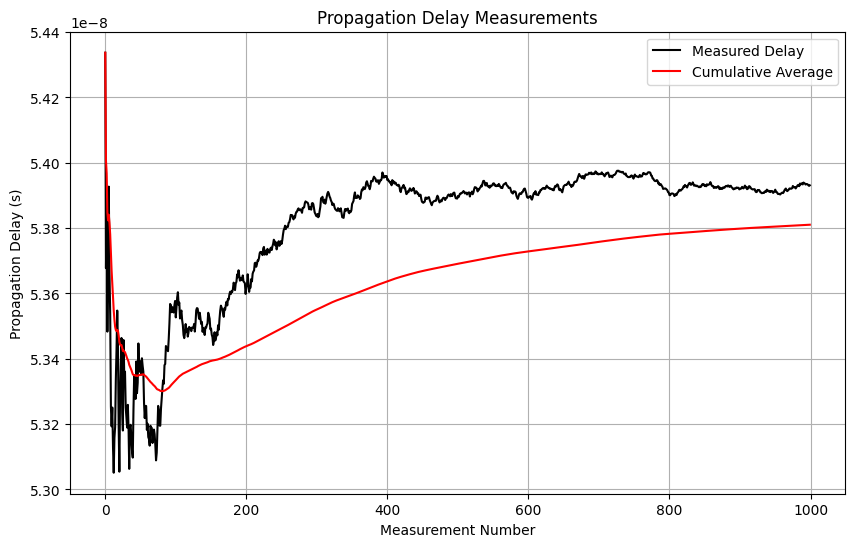

Average measured delay: 53.81 ns
Final cumulative average: 53.81 ns
Min delay: 53.05 ns
Max delay: 54.34 ns

Analyzing and plotting synchronization results...


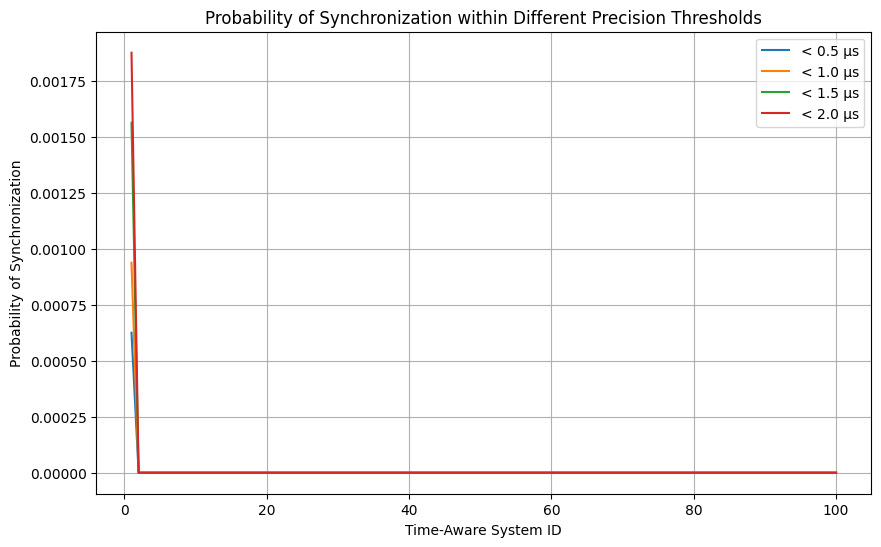

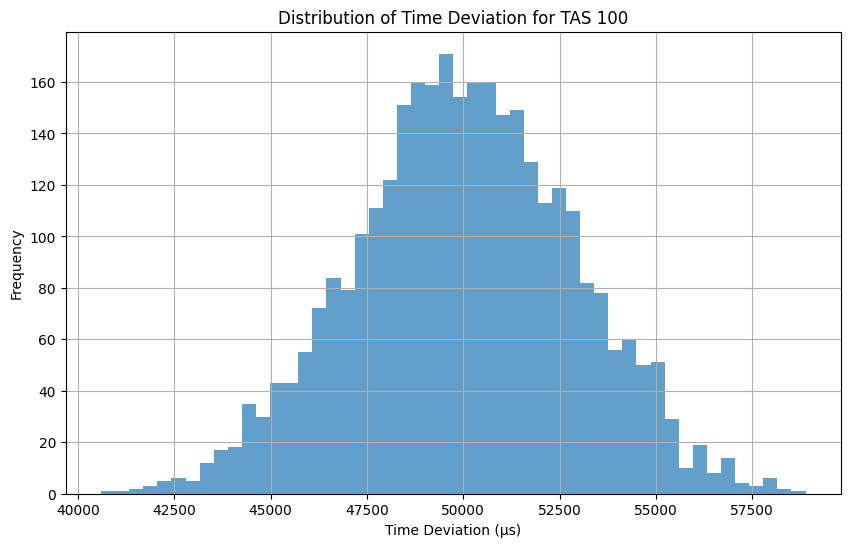

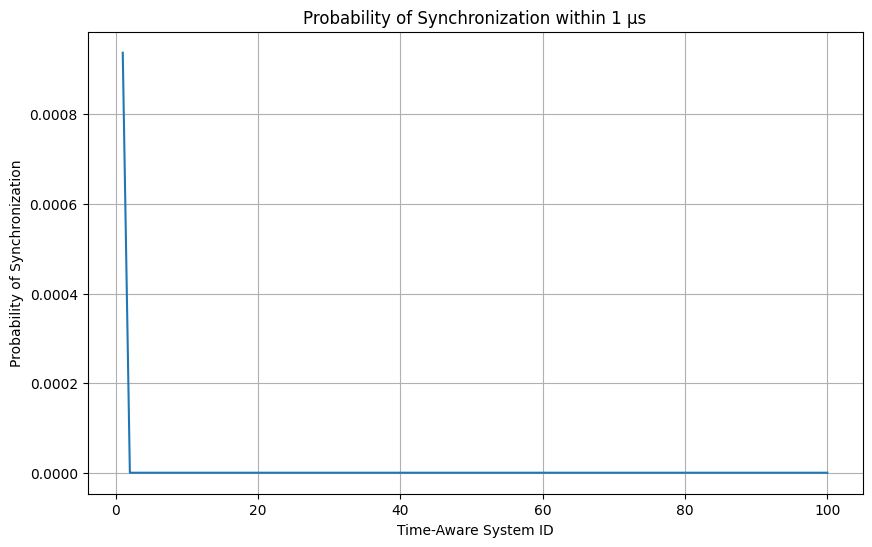


Visualization completed!
Number of time-aware systems: 100
Probability of synchronization within 1 μs for TAS 10: 0.0000
Probability of synchronization within 1 μs for TAS 30: 0.0000
Probability of synchronization within 1 μs for TAS 50: 0.0000
Probability of synchronization within 1 μs for TAS 100: 0.0000

Results saved as images:


In [4]:
"""
**************************************
*  @Author  ：   mag1cfox
*  @Time    ：   2025/3/20 10:30
*  @Project :   pj_gptp_simulation
*  @Description :   Visualize simulation results from CSV
*  @FileName:   data_visualizer.py
**************************************
"""
import csv
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def load_sync_data(filename="output_data/simulation_results.csv"):
    data = defaultdict(list)
    with open(filename, "r") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            tas_id = int(row["TAS_ID"])
            time = float(row["Time"])
            error = float(row["Time_Error"])
            data[tas_id].append((time, error))
    return data

def load_propagation_delay_data(filename="output_data/propagation_delay.csv"):
    measurements = []
    delays = []
    avg_delays = []
    with open(filename, "r") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            measurements.append(int(row["Measurement"]))
            delays.append(float(row["Delay"]))
            avg_delays.append(float(row["Cumulative_Avg"]))
    return measurements, delays, avg_delays

def analyze_and_plot(sync_data, precision_thresholds=[0.5e-6, 1e-6, 1.5e-6, 2e-6]):
    # 同步精度概率分析
    precision_probabilities = {threshold: {} for threshold in precision_thresholds}

    for threshold in precision_thresholds:
        for tas_id in sync_data:
            in_sync_count = sum(1 for _, error in sync_data[tas_id] if error < threshold)
            total_count = len(sync_data[tas_id])
            probability = in_sync_count / total_count if total_count > 0 else 0
            precision_probabilities[threshold][tas_id] = probability

    # 确保输出目录存在
    import os
    os.makedirs("output_image", exist_ok=True)

    # 绘制同步精度概率图
    plt.figure(figsize=(10, 6))
    for threshold in precision_thresholds:
        tas_ids = list(precision_probabilities[threshold].keys())
        probabilities = list(precision_probabilities[threshold].values())
        plt.plot(tas_ids, probabilities, label=f'< {threshold * 1e6:.1f} μs')

    plt.xlabel('Time-Aware System ID')
    plt.ylabel('Probability of Synchronization')
    plt.title('Probability of Synchronization within Different Precision Thresholds')
    plt.legend()
    plt.grid(True)
    plt.savefig('output_image/sync_probability.png')
    plt.show()
    plt.close()

    # 绘制时间误差分布图（最后一个设备）
    last_tas_id = max(sync_data.keys())
    errors = [error for _, error in sync_data[last_tas_id]]

    plt.figure(figsize=(10, 6))
    plt.hist(np.array(errors) * 1e6, bins=50, alpha=0.7)
    plt.xlabel('Time Deviation (μs)')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Time Deviation for TAS {last_tas_id}')
    plt.grid(True)
    plt.savefig('output_image/time_deviation_distribution.png')
    plt.show()
    plt.close()

    # 绘制1μs同步概率曲线
    tas_ids = list(precision_probabilities[1e-6].keys())
    probabilities = list(precision_probabilities[1e-6].values())

    plt.figure(figsize=(10, 6))
    plt.plot(tas_ids, probabilities)
    plt.xlabel('Time-Aware System ID')
    plt.ylabel('Probability of Synchronization')
    plt.title('Probability of Synchronization within 1 μs')
    plt.grid(True)
    plt.savefig('output_image/sync_probability_1us.png')
    plt.show()
    plt.close()

    # 返回结果
    return precision_probabilities

def plot_propagation_delay(measurements, delays, avg_delays):
    # 确保输出目录存在
    import os
    os.makedirs("output_image", exist_ok=True)

    # 绘制传播延迟图
    plt.figure(figsize=(10, 6))
    plt.plot(delays, 'k-', label='Measured Delay')
    plt.plot(avg_delays, 'r-', label='Cumulative Average')
    # plt.axhline(y=50e-9, color='b', linestyle='--', label='Real Delay (50 ns)')
    plt.xlabel('Measurement Number')
    plt.ylabel('Propagation Delay (s)')
    plt.title('Propagation Delay Measurements')
    plt.legend()
    plt.grid(True)
    plt.savefig('output_image/propagation_delay.png')
    plt.show()
    plt.close()

    # 打印结果
    print(f"Average measured delay: {np.mean(delays) * 1e9:.2f} ns")
    print(f"Final cumulative average: {avg_delays[-1] * 1e9:.2f} ns")
    print(f"Min delay: {min(delays) * 1e9:.2f} ns")
    print(f"Max delay: {max(delays) * 1e9:.2f} ns")

if __name__ == "__main__":
    # 加载数据
    print("Loading simulation data...")
    sync_data = load_sync_data()
    measurements, delays, avg_delays = load_propagation_delay_data()

    # 绘制传播延迟图
    print("\nPlotting propagation delay results...")
    plot_propagation_delay(measurements, delays, avg_delays)

    # 分析并绘制同步结果
    print("\nAnalyzing and plotting synchronization results...")
    precision_probabilities = analyze_and_plot(sync_data)

    # 打印结果摘要
    print("\nVisualization completed!")
    print(f"Number of time-aware systems: {len(sync_data)}")
    
    # 打印不同跳数设备的同步精度概率
    for hop in [10, 30, 50, 100]:
        if hop in precision_probabilities[1e-6]:
            print(f"Probability of synchronization within 1 μs for TAS {hop}: {precision_probabilities[1e-6][hop]:.4f}")

    print("\nResults saved as images:")


## 绘制延迟图

Loading simulation data...

Plotting propagation delay results...


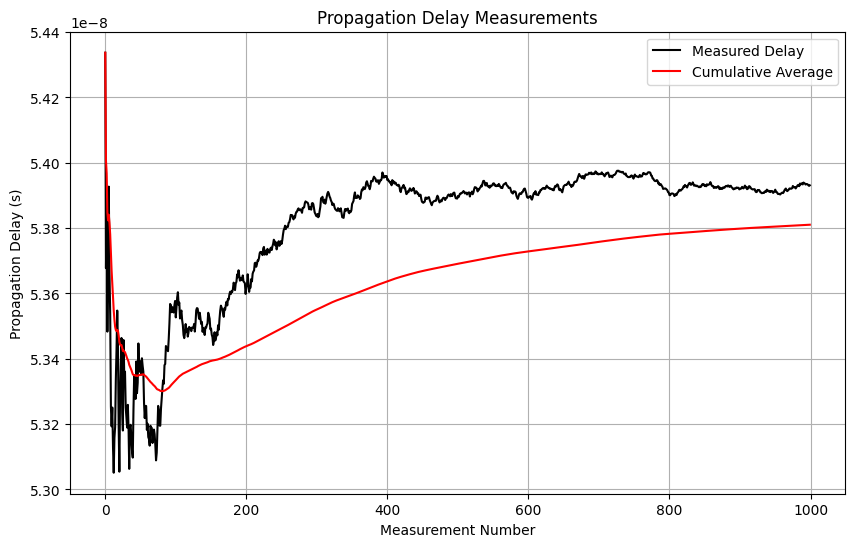

Average measured delay: 53.81 ns
Final cumulative average: 53.81 ns
Min delay: 53.05 ns
Max delay: 54.34 ns


In [6]:
"""
**************************************
*  @Author  ：   mag1cfox
*  @Time    ：   2025/3/20 10:30
*  @Project :   pj_gptp_simulation
*  @Description :   Visualize simulation results from CSV
*  @FileName:   data_visualizer.py
**************************************
"""
import csv
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def load_sync_data(filename="output_data/simulation_results.csv"):
    data = defaultdict(list)
    with open(filename, "r") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            tas_id = int(row["TAS_ID"])
            time = float(row["Time"])
            error = float(row["Time_Error"])
            data[tas_id].append((time, error))
    return data

def load_propagation_delay_data(filename="output_data/propagation_delay.csv"):
    measurements = []
    delays = []
    avg_delays = []
    with open(filename, "r") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            measurements.append(int(row["Measurement"]))
            delays.append(float(row["Delay"]))
            avg_delays.append(float(row["Cumulative_Avg"]))
    return measurements, delays, avg_delays

def plot_propagation_delay(measurements, delays, avg_delays):
    # 确保输出目录存在
    import os
    os.makedirs("output_image", exist_ok=True)

    # 绘制传播延迟图
    plt.figure(figsize=(10, 6))
    plt.plot(delays, 'k-', label='Measured Delay')
    plt.plot(avg_delays, 'r-', label='Cumulative Average')
    # plt.axhline(y=50e-9, color='b', linestyle='--', label='Real Delay (50 ns)')
    plt.xlabel('Measurement Number')
    plt.ylabel('Propagation Delay (s)')
    plt.title('Propagation Delay Measurements')
    plt.legend()
    plt.grid(True)
    plt.savefig('output_image/propagation_delay.png')
    plt.show()
    plt.close()

    # 打印结果
    print(f"Average measured delay: {np.mean(delays) * 1e9:.2f} ns")
    print(f"Final cumulative average: {avg_delays[-1] * 1e9:.2f} ns")
    print(f"Min delay: {min(delays) * 1e9:.2f} ns")
    print(f"Max delay: {max(delays) * 1e9:.2f} ns")

if __name__ == "__main__":
    # 加载数据
    print("Loading simulation data...")
    sync_data = load_sync_data()
    measurements, delays, avg_delays = load_propagation_delay_data()

    # 绘制传播延迟图
    print("\nPlotting propagation delay results...")
    plot_propagation_delay(measurements, delays, avg_delays)

